In [1]:
# Check Python Version (Itsuki is using anaconda3)
import sys
import platform

print(sys.version)
print(platform.architecture()[0]) # Check whether 32 or 64bit

3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 21:00:12) [Clang 16.0.6 ]
64bit


# Analysis Roadmap (逐次更新)
## Preconditions
- No mice in ocean
  - 海岸線の緯度と経度を得て，海岸線より海側のネズミ発生確率を0に
## Method
- Related Indicators
  - Temperature
  - Population density (mesh data?)
  - Altitude（∝1/temperature?）
  - Species（各ネズミの大まかな生息条件を調べられるとbetter）
  - Family Tree
- 簡単のために，X軸: 経度，Y軸: 緯度の2次元平面上で表現→この平面上に海岸線を描画できる？
- 数kmメッシュに区切って，各メッシュのネズミ発生確率を予測する
  - ただし，学習データ上でネズミの発生確率が0となる: limitation
  - もちろん海上のメッシュは発生確率0
  - 図を見る限り緯度経度0.2度メッシュくらいが現実的に解析可能そうなライン？

# Key Takeaways (逐次更新)
- .shpなど地理データをGeoDataFrameにする時は正しいCRS (Coordinate Reference System; 例えば[EPSG:3035](https://epsg.io/3035))の指定が肝要
- [主観]質の高い地理データはEUとUSに多い印象
- [主観]降水量などの時系列データは.nc (NetCDF)が多い

In [2]:
import pandas as pd
import sqlite3

In [3]:
# Start Connection with SQLite
file_sqlite3 = "data/OpenMICE-August_2018/OpenMICE.sqlite"
conn = sqlite3.connect(file_sqlite3)
df_mice=pd.read_sql_query('SELECT * FROM data LEFT JOIN sites_information on data.sites_information_id = sites_information.id LEFT JOIN coordinates ON sites_information.coordinates_id = coordinates.id LEFT JOIN species_information ON data.species_information_id = species_information.id', conn)
conn.close()

In [4]:
df_mice = df_mice.drop('id', axis=1)
df_mice["id"] = df_mice.index + 1
print(df_mice.head())
df_mice.to_csv('data/mice.csv', index=True)

   inserted_by_id  species_information_id  sites_information_id event_date  \
0               1                       9                    13   26/06/16   
1               1                      22                    29   06/09/16   
2               1                      11                    29   06/09/16   
3               1                       3                    29   06/09/16   
4               1                      24                    29   06/09/16   

   predators_information_id identified_by_id references_id dataset_name_id  \
0                         4               33            44               2   
1                         5               33            44               2   
2                         5               33            44               2   
3                         5               33            44               2   
4                         5               33            44               2   

   institution_id  rigths_holder_id  ...  references_id_26  \


In [5]:
df_mice = pd.read_csv("data/mice.csv",index_col=False)

In [6]:
df_mice.columns

Index(['Unnamed: 0', 'inserted_by_id', 'species_information_id',
       'sites_information_id', 'event_date', 'predators_information_id',
       'identified_by_id', 'references_id', 'dataset_name_id',
       'institution_id', 'rigths_holder_id', 'recorded_by_id',
       'individual_count', 'occurrence_code', 'coordinates_id', 'locality',
       'verbatim_locality', 'municipality', 'province', 'region',
       'georeferenced_by_id', 'georeferenced_sources_id',
       'coordinate_precision_id', 'elevation_in_meters', 'latitude',
       'longitude', 'geometry', 'class', 'order', 'family', 'genus', 'species',
       'scientific_name', 'accepted_name_usage', 'common_name',
       'references_id_1', 'iucn_national_status', 'references_id_2',
       'habitat_directive', 'references_id_3', 'trophic_level_id',
       'references_id_4', 'prevalent_habit_id', 'references_id_5',
       'activity_pattern_id', 'references_id_6', 'guild_id', 'references_id_7',
       'habitat_preference_id', 'referen

In [7]:
# Choose only usable data (drop unnecessary data like id)
df_mice = df_mice[["id","event_date","latitude","longitude","scientific_name"]]

In [8]:
df_mice.head()

,id,event_date,latitude,longitude,scientific_name
0,1,26/06/16,41.42149,14.49559,Glis glis
1,2,06/09/16,41.58721,14.18007,Sorex antinorii
2,3,06/09/16,41.58721,14.18007,Microtus savii
3,4,06/09/16,41.58721,14.18007,Apodemus sylvaticus
4,5,06/09/16,41.58721,14.18007,Sorex samniticus


In [9]:
print(f'length of df_mice: {len(df_mice)}')

length of df_mice: 1999


In [10]:
df_mice[["scientific_name"]].value_counts()

scientific_name         
Microtus savii              260
Apodemus sp.                205
Suncus etruscus             177
Crocidura leucodon          170
Crocidura suaveolens        168
Mus domesticus              164
Muscardinus avellanarius    128
Rattus rattus               110
Apodemus sylvaticus          94
Myodes glareolus             93
Sorex sp.                    81
Sorex samniticus             71
Crocidura sp.                44
Sorex minutus                36
Rattus sp.                   34
Apodemus flavicollis         32
Talpa romana                 18
Arvicola italicus            16
Neomys milleri               13
Sorex antinorii              12
Rattus norvegicus            11
Eliomys quercinus            10
Neomys sp.                   10
Glis glis                     8
Neomys fodiens                7
Microtus multiplex            4
Talpa sp.                     4
Talpa caeca                   3
Sciurus vulgaris              1
Name: count, dtype: int64

In [11]:
# Check NA
df_mice.isna().sum()

id                  0
event_date          0
latitude            0
longitude           0
scientific_name    15
dtype: int64

→欠損値多め．かなぴ

# Data Visualisation

## Geo - Map

In [12]:
# It is not recommended to use pip to install geopandas: https://geopandas.org/en/stable/getting_started/install.html
# Better to use Conda instead of pip
# %conda install geopandas

In [13]:
import geopandas as gpd

In [14]:
gdf_mice = gpd.GeoDataFrame(df_mice, 
            geometry=gpd.points_from_xy(df_mice.longitude, df_mice.latitude),
            crs="EPSG:4326" # This line is really important to make coordinate machine readable
)
gdf_mice.drop(columns=['longitude', 'latitude'])

,id,event_date,scientific_name,geometry
0,1,26/06/16,Glis glis,POINT (14.49559 41.42149)
1,2,06/09/16,Sorex antinorii,POINT (14.18007 41.58721)
2,3,06/09/16,Microtus savii,POINT (14.18007 41.58721)
3,4,06/09/16,Apodemus sylvaticus,POINT (14.18007 41.58721)
4,5,06/09/16,Sorex samniticus,POINT (14.18007 41.58721)
...,...,...,...,...
1994,1995,00/00/1996,Crocidura suaveolens,POINT (12.41809 41.77606)
1995,1996,00/00/1996,Muscardinus avellanarius,POINT (12.41809 41.77606)
1996,1997,00/00/1996,Microtus savii,POINT (12.41809 41.77606)
1997,1998,00/00/1996,Apodemus sp.,POINT (12.41809 41.77606)


In [ ]:
# import folium

# # # Create a map centered around the mean latitude and longitude
# m = folium.Map(location=[gdf_mice['latitude'].mean(), gdf_mice['longitude'].mean()])

# # # Add the GeoDataFrame to the map as markers
# for idx, row in gdf_mice.iterrows():
#     folium.Marker(location=[row['latitude'], row['longitude']], popup=row['scientific_name']).add_to(m)

# # # Display the map
# m

## Geo - XY-coordinate

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='longitude', ylabel='latitude'>

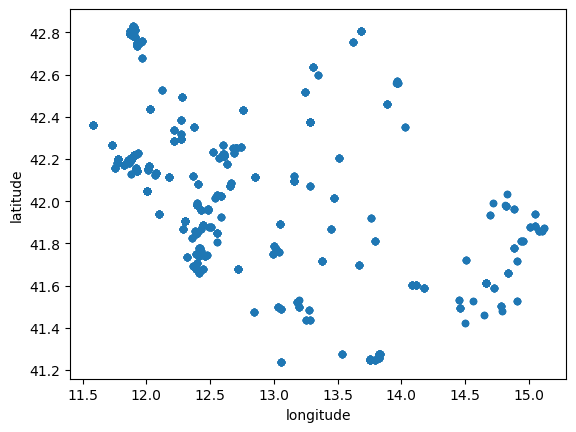

In [17]:
# 2次元平面上に可視化
df_mice.plot.scatter(x="longitude",y="latitude")

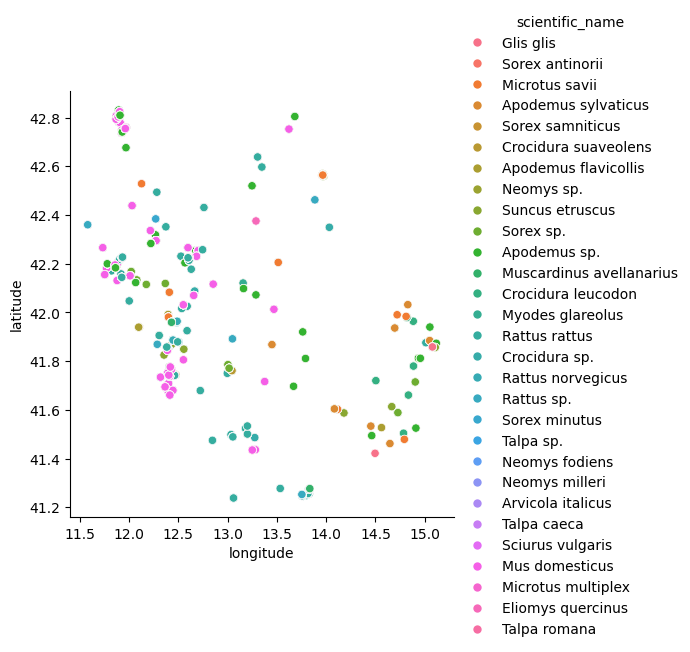

In [18]:
# マウスの種類別に可視化
sns.relplot(data=df_mice, x="longitude", y="latitude", hue="scientific_name")
plt.show()

→種類が多すぎるので，とりあえずscientific_nameは無視でもいいかも

## Latitude and Longitude

In [19]:
print(f'latitude_max: {df_mice["latitude"].max()}')
print(f'latitude_min: {df_mice["latitude"].min()}')
print(f'longitude_max: {df_mice["longitude"].max()}')
print(f'longitude_min: {df_mice["longitude"].min()}')

latitude_max: 42.83102
latitude_min: 41.23798
longitude_max: 15.11688
longitude_min: 11.58002


→latitudeとlongitudeの変域
- latitude = [41,42]
- longitude = [11,16]

# Prediction

- 使えそうなデータ
  - ネズミの親子関係（from OpenMICE）
  - 

# Data Analysis

## Gridding of point data with geopandas
Refer to: https://james-brennan.github.io/posts/fast_gridding_geopandas/


In [20]:
gdf_mice.head()

,id,event_date,latitude,longitude,scientific_name,geometry
0,1,26/06/16,41.42149,14.49559,Glis glis,POINT (14.49559 41.42149)
1,2,06/09/16,41.58721,14.18007,Sorex antinorii,POINT (14.18007 41.58721)
2,3,06/09/16,41.58721,14.18007,Microtus savii,POINT (14.18007 41.58721)
3,4,06/09/16,41.58721,14.18007,Apodemus sylvaticus,POINT (14.18007 41.58721)
4,5,06/09/16,41.58721,14.18007,Sorex samniticus,POINT (14.18007 41.58721)


In [21]:
world_path = "data/COAS_RG_20M_2016_3035/COAS_RG_20M_2016_3035.shp"
gdf_world = gpd.read_file(world_path, crs="EPSG:3035")
gdf_world.head()

,COAS_ID,FID,geometry
0,1,1,"POLYGON ((11851260.434 6576391.596, 11868666.6..."
1,2,2,"POLYGON ((-1609517.181 -6509412.671, -1562130...."
2,3,3,"POLYGON ((2486296.605 7635743.437, 2476586.837..."
3,4,4,"POLYGON ((14351721.391 8624477.394, 14394710.5..."
4,6,6,"POLYGON ((3513167.258 7276604.460, 3488015.963..."


<Axes: >

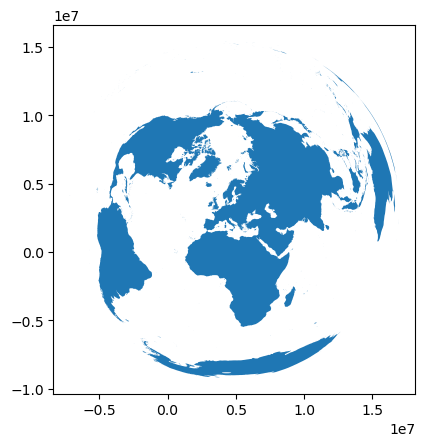

In [22]:
gdf_world.plot()

<Axes: >

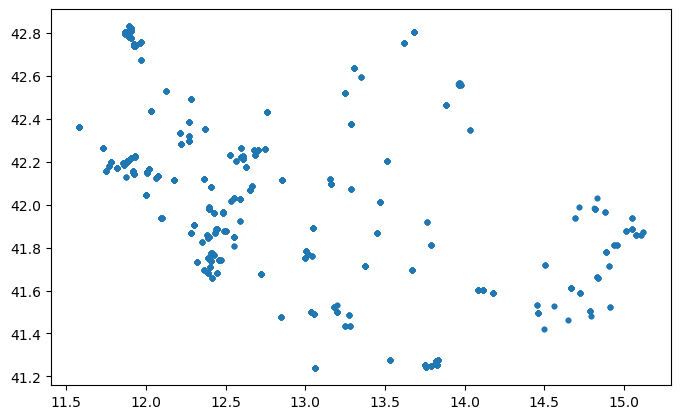

In [23]:
gdf_mice.plot(markersize=10, figsize=(8, 8))

<Axes: >

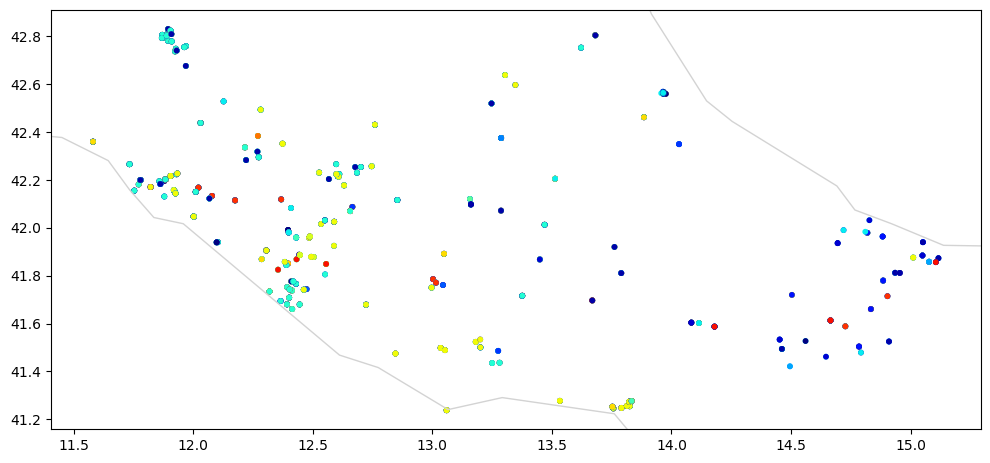

In [269]:
ax = gdf_mice.plot(markersize=10, figsize=(12, 8), column='scientific_name', cmap='jet')
plt.autoscale(False)
gdf_world.to_crs(gdf_mice.crs).plot(ax=ax, color='none', edgecolor='lightgrey')

In [25]:
import numpy as np
import shapely
np.random.seed(42) # Don't panic!

## Example of Creating Grid

In [26]:
# total area for the grid
xmin, ymin, xmax, ymax= gdf_mice.total_bounds
# how many cells across and down
# In this case, cell size is 1/30*(max_latitude - min_latitude)
n_cells=30
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "EPSG:4326"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

(11.403177, 15.293723, 41.158328, 42.910672000000005)

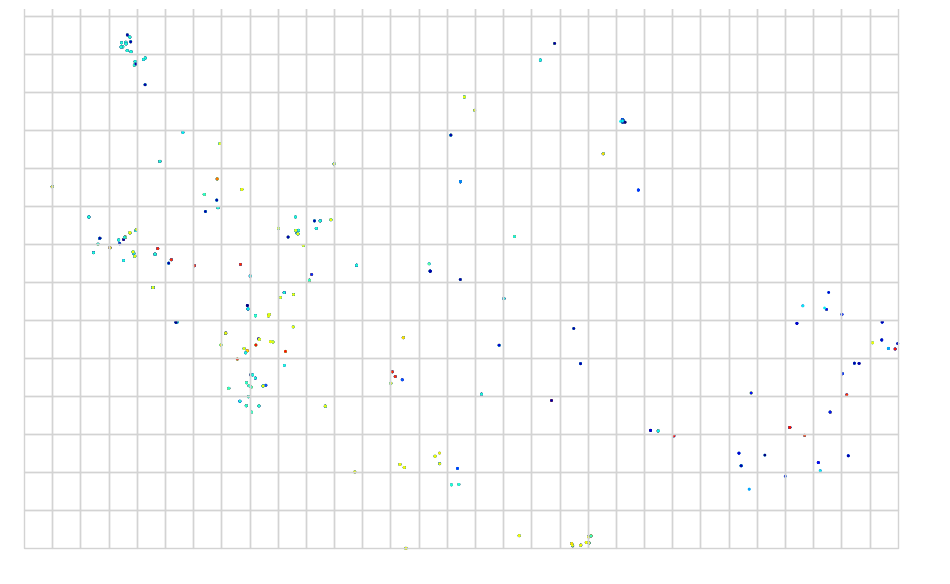

In [27]:
ax = gdf_mice.plot(markersize=1, figsize=(12, 8), column='scientific_name', cmap='jet')
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='lightgrey')
ax.axis("off")

In [28]:
gdf_mice_merged = gpd.sjoin(gdf_mice, cell, how='left', predicate='within')

In [29]:
gdf_mice_merged.head()

,id,event_date,latitude,longitude,scientific_name,geometry,index_right
0,1,26/06/16,41.42149,14.49559,Glis glis,POINT (14.49559 41.42149),376.0
1,2,06/09/16,41.58721,14.18007,Sorex antinorii,POINT (14.18007 41.58721),347.0
2,3,06/09/16,41.58721,14.18007,Microtus savii,POINT (14.18007 41.58721),347.0
3,4,06/09/16,41.58721,14.18007,Apodemus sylvaticus,POINT (14.18007 41.58721),347.0
4,5,06/09/16,41.58721,14.18007,Sorex samniticus,POINT (14.18007 41.58721),347.0


In [30]:
# make a simple count variable that we can sum
gdf_mice_merged['mice_occurrence']=1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = gdf_mice_merged.dissolve(by="index_right", aggfunc="count")
# put this into cell
cell.loc[dissolve.index, 'mice_occurrence'] = dissolve.mice_occurrence.values

In [31]:
cell.head()

,geometry,mice_occurrence
0,"POLYGON ((11.46212 41.23798, 11.46212 41.35588...",NaN
1,"POLYGON ((11.46212 41.35588, 11.46212 41.47377...",NaN
2,"POLYGON ((11.46212 41.47377, 11.46212 41.59167...",NaN
3,"POLYGON ((11.46212 41.59167, 11.46212 41.70956...",NaN
4,"POLYGON ((11.46212 41.70956, 11.46212 41.82746...",NaN


In [32]:
cell["mice_occurrence"].max()

122.0

<Axes: >

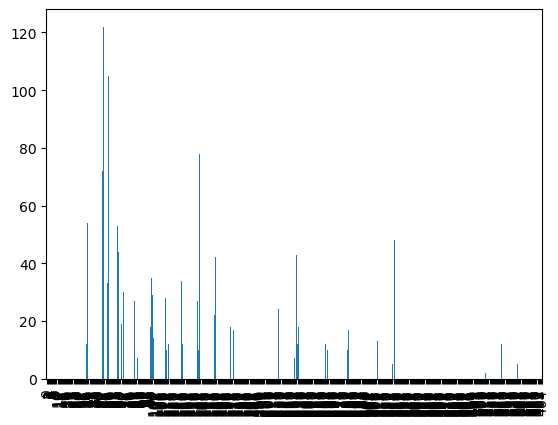

In [33]:
cell["mice_occurrence"].plot(kind='bar')


(11.5269671, 15.287828233333329, 41.15545326666666, 42.971041400000054)

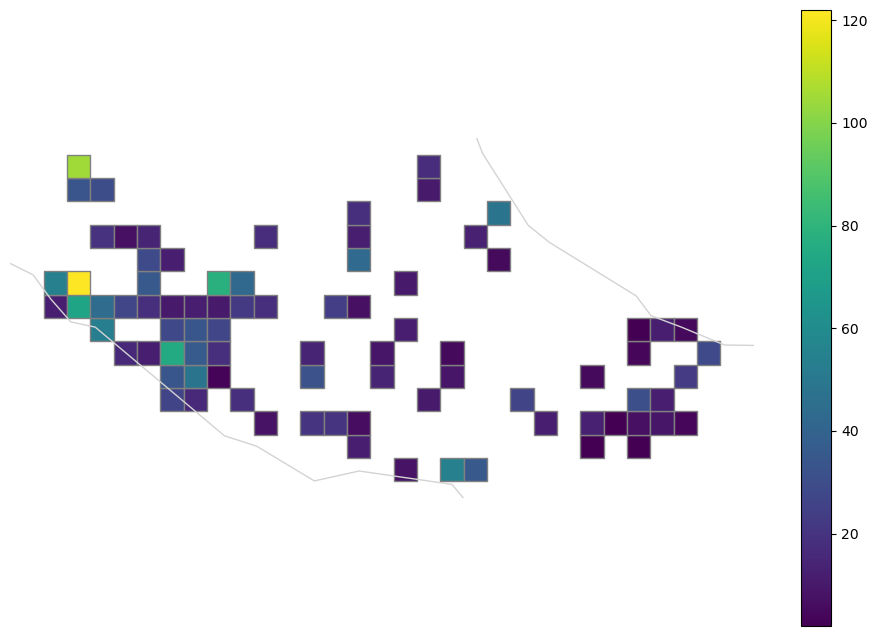

In [34]:
ax = cell.plot(column='mice_occurrence', figsize=(12, 8), cmap='viridis', vmax=122, edgecolor="grey", legend=True)
plt.autoscale(False)
plt.colormaps()
gdf_world.to_crs(cell.crs).plot(ax=ax, color='none', edgecolor='lightgrey')
ax.axis('off')

## Flow of Analysis (tentative)
1. gridにid付ける
2. gdf_mice内にgrid_idを入れる
3. grid_idごとにねずみの発生しやすさを求める(should define "発生しやすさ")
4. →gridごとの気温と人口密度（+ねずみの発生を予測しそうな外的要因）を持ってきて，それらの変数からmiceの発生しやすさをモデル化する

miceの発生しやすさ: "likelihood of mice occurrence" (以下"lhmo")
- gridの"lhmo"が大きいほどmiceの報告数が多くなるようにしたい
- 目標: mice_occurrence > 0を元データにして，mice_occurrence = 0のgrid内でのmice_occurrenceの数を予測する
  - holdoutなら，train_data: 80% of total grids (もちろんgrid[mice_occurrence] != 0), test_data: 20% of total gridsみたいな感じ
  - →これで精度を挙げて，grids whose mice_occurrence = 0のmice_occurrenceを予測する

- Problem: 気温や人口のデータがEU圏内，もしくはイタリアでどのような地区単位で収集されているのか知る必要がある．
  - [人口]1km四方のpolygon population dataが存在: https://ec.europa.eu/eurostat/web/gisco/geodata/grids
  - [平均気温]
  - [平均標高]

In [76]:
# 人口密度メッシュ（5km四方）
gdf_grid_5km = gpd.read_file("data/grid/grid_5km_surf.gpkg")

In [78]:
gdf_grid_5km = gdf_grid_5km[gdf_grid_5km["CNTR_ID"] == "IT"]

In [79]:
gdf_grid_5km.head()

,DIST_BORD,TOT_P_2018,TOT_P_2006,GRD_ID,TOT_P_2011,TOT_P_2021,Y_LLC,CNTR_ID,NUTS2016_3,NUTS2016_2,NUTS2016_1,NUTS2016_0,LAND_PC,X_LLC,NUTS2021_3,NUTS2021_2,DIST_COAST,NUTS2021_1,NUTS2021_0,geometry
249,7329.919922,23.0,2.0,CRS3035RES5000mN2510000E4090000,25.0,24,2510000,IT,ITC20,ITC2,ITC,IT,100.0,4090000,ITC20,ITC2,188582.968750,ITC,IT,"POLYGON ((4090000.000 2510000.000, 4095000.000..."
250,11601.150391,664.0,680.0,CRS3035RES5000mN2510000E4095000,671.0,797,2510000,IT,ITC20,ITC2,ITC,IT,100.0,4095000,ITC20,ITC2,185743.750000,ITC,IT,"POLYGON ((4095000.000 2510000.000, 4100000.000..."
251,16286.799805,3167.0,3294.0,CRS3035RES5000mN2510000E4100000,3119.0,3034,2510000,IT,ITC20,ITC2,ITC,IT,100.0,4100000,ITC20,ITC2,182995.031250,ITC,IT,"POLYGON ((4100000.000 2510000.000, 4105000.000..."
252,19567.919922,3069.0,2862.0,CRS3035RES5000mN2510000E4105000,3069.0,3110,2510000,IT,ITC20,ITC2,ITC,IT,100.0,4105000,ITC20,ITC2,180339.656250,ITC,IT,"POLYGON ((4105000.000 2510000.000, 4110000.000..."
253,21305.480469,348.0,873.0,CRS3035RES5000mN2510000E4110000,334.0,384,2510000,IT,ITC20,ITC2,ITC,IT,100.0,4110000,ITC20,ITC2,177785.296875,ITC,IT,"POLYGON ((4110000.000 2510000.000, 4115000.000..."


<Axes: >

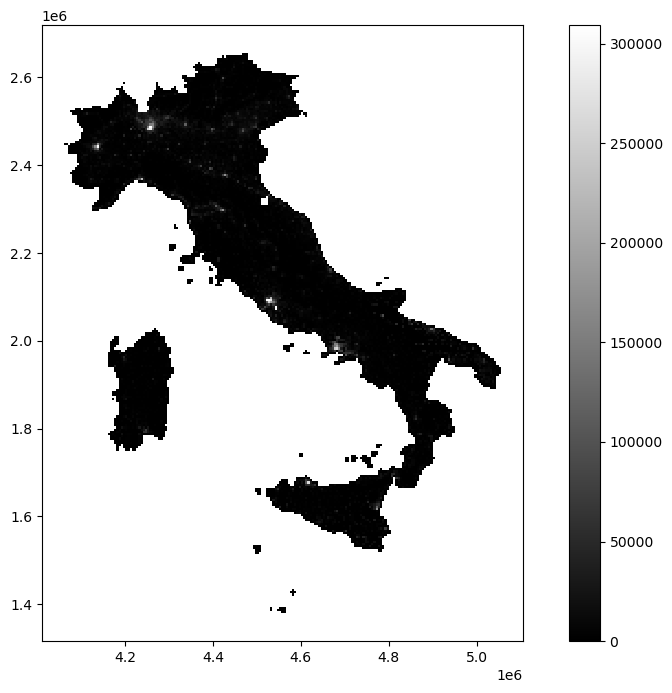

In [137]:
gdf_grid_5km.plot(column="TOT_P_2021", cmap="grey", figsize=(12,8), legend=True)

In [39]:
import matplotlib.colors as colors

In [49]:
def plot_gdfs(gdf_scatter, gdf_base, lognorm):
    title = ""
    if lognorm:
        norm = colors.LogNorm()
        title = "Population Density (LogNorm)"
    else:
        norm = None
        title = "Population Density"
    ax = gdf_scatter.plot(figsize=(12, 8), markersize=0)
    plt.title(title + " " + "and Mice Occurrence")
    plt.autoscale(False)
    gdf_base.to_crs(gdf_scatter.crs).plot(ax=ax, cmap="gray", column="TOT_P_2021", edgecolor='lightgrey', norm=norm, legend=True)
    gdf_scatter.plot(ax=ax, markersize=10, figsize=(12, 8))

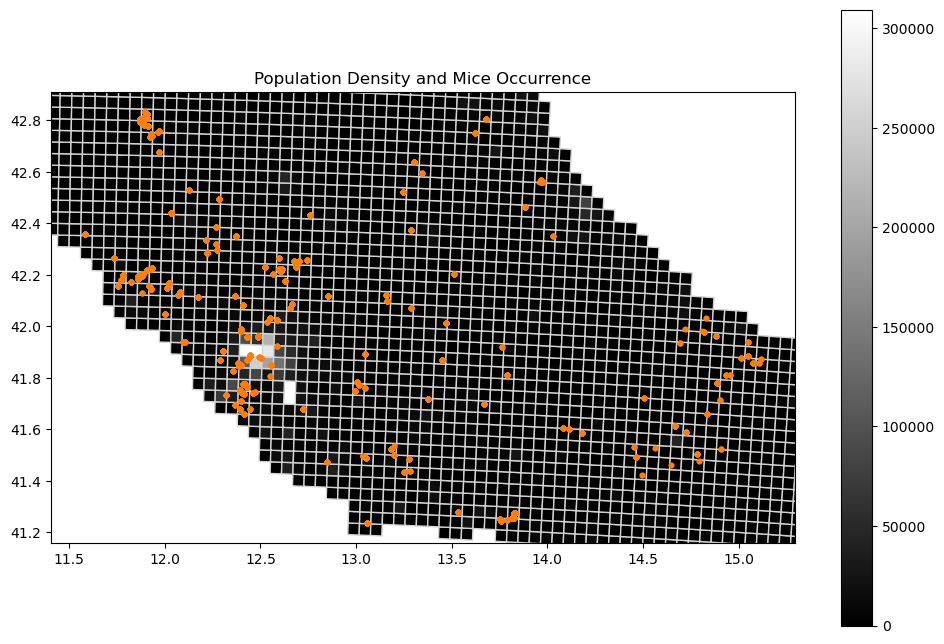

In [326]:
plot_gdfs(gdf_mice,gdf_grid_5km,False)

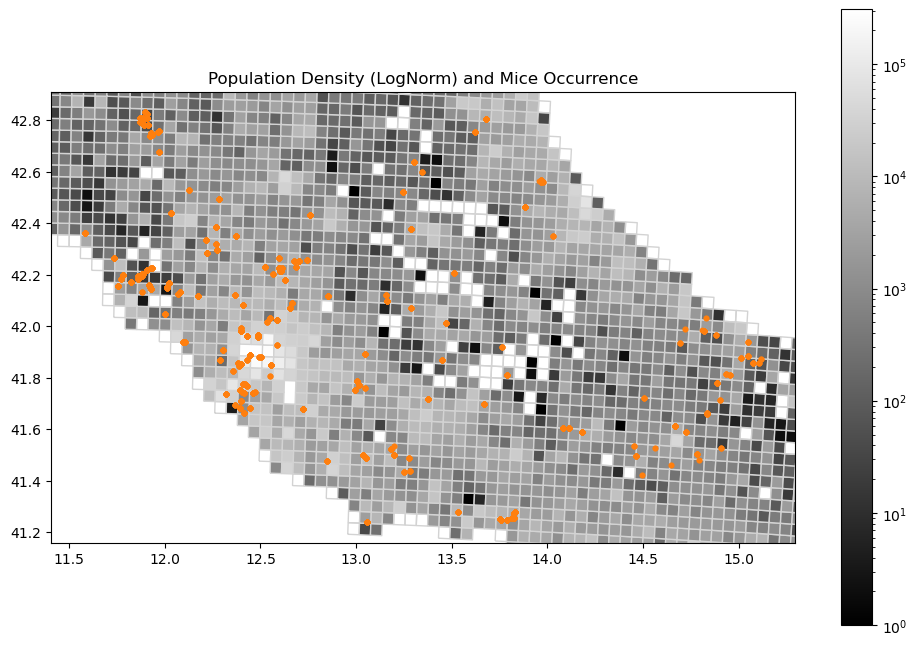

In [51]:
# 人口密度が見えにくいのでLogarithmic Normalisationした
## Refer to: https://matplotlib.org/stable/users/explain/colors/colormapnorms.html

plot_gdfs(gdf_mice,gdf_grid_5km,True)

## Flow of Analysis (from now on)
- gdf_grid_5kmに["mice_occurrence", "temperature", "avg_altitude", "precipitation(降水量)","緑化率","耕作地率"]などを突っ込み，grid[mice_occurrence != 0]でモデル作成→モデルをgrid[mice_occurrence = 0]に当てはめてMice_occurrence mapを作成
  1. Gridの中心地点（Grid二対角線の交点）を求めて，gdf_grid_5km["ctr_co"] (="center coordinate")に挿入
  2. Temperature, avg_altitudeは，gridの中心地点（二対角線の交点）に最寄りの（latitude, longitudeの差の二乗和が最も小さい）データを取ってくる
  - Temperatureとavg_altitudeはある程度相関していそうなので，多重共線性（"Multicollinearity", "マルティコ"）に注意

## Think with Grid

In [70]:
gdf_mice.head()

,id,event_date,latitude,longitude,scientific_name,geometry
0,1,26/06/16,41.42149,14.49559,Glis glis,POINT (14.49559 41.42149)
1,2,06/09/16,41.58721,14.18007,Sorex antinorii,POINT (14.18007 41.58721)
2,3,06/09/16,41.58721,14.18007,Microtus savii,POINT (14.18007 41.58721)
3,4,06/09/16,41.58721,14.18007,Apodemus sylvaticus,POINT (14.18007 41.58721)
4,5,06/09/16,41.58721,14.18007,Sorex samniticus,POINT (14.18007 41.58721)


In [71]:
gdf_grid_5km.head()

,DIST_BORD,TOT_P_2018,TOT_P_2006,GRD_ID,TOT_P_2011,TOT_P_2021,Y_LLC,CNTR_ID,NUTS2016_3,NUTS2016_2,...,NUTS2016_0,LAND_PC,X_LLC,NUTS2021_3,NUTS2021_2,DIST_COAST,NUTS2021_1,NUTS2021_0,geometry,mice_occurrence
249,7329.919922,23.0,2.0,CRS3035RES5000mN2510000E4090000,25.0,24,2510000,IT,ITC20,ITC2,...,IT,100.0,4090000,ITC20,ITC2,188582.968750,ITC,IT,"POLYGON ((4090000.000 2510000.000, 4095000.000...",NaN
250,11601.150391,664.0,680.0,CRS3035RES5000mN2510000E4095000,671.0,797,2510000,IT,ITC20,ITC2,...,IT,100.0,4095000,ITC20,ITC2,185743.750000,ITC,IT,"POLYGON ((4095000.000 2510000.000, 4100000.000...",NaN
251,16286.799805,3167.0,3294.0,CRS3035RES5000mN2510000E4100000,3119.0,3034,2510000,IT,ITC20,ITC2,...,IT,100.0,4100000,ITC20,ITC2,182995.031250,ITC,IT,"POLYGON ((4100000.000 2510000.000, 4105000.000...",NaN
252,19567.919922,3069.0,2862.0,CRS3035RES5000mN2510000E4105000,3069.0,3110,2510000,IT,ITC20,ITC2,...,IT,100.0,4105000,ITC20,ITC2,180339.656250,ITC,IT,"POLYGON ((4105000.000 2510000.000, 4110000.000...",NaN
253,21305.480469,348.0,873.0,CRS3035RES5000mN2510000E4110000,334.0,384,2510000,IT,ITC20,ITC2,...,IT,100.0,4110000,ITC20,ITC2,177785.296875,ITC,IT,"POLYGON ((4110000.000 2510000.000, 4115000.000...",NaN


In [114]:
# Insert "mice_occurrence" (the number of mice observed in the grid) in gdf_grid_5km
gdf_grid_5km_merged = gdf_grid_5km.join(
    gpd.sjoin(gdf_mice.to_crs(gdf_grid_5km.crs), gdf_grid_5km).groupby("index_right").size().rename("mice_occurrence"),
    how="left",
)

In [104]:
gdf_grid_5km_merged.head()

,DIST_BORD,TOT_P_2018,TOT_P_2006,GRD_ID,TOT_P_2011,TOT_P_2021,Y_LLC,CNTR_ID,NUTS2016_3,NUTS2016_2,...,NUTS2016_0,LAND_PC,X_LLC,NUTS2021_3,NUTS2021_2,DIST_COAST,NUTS2021_1,NUTS2021_0,geometry,mice_occurrence
249,7329.919922,23.0,2.0,CRS3035RES5000mN2510000E4090000,25.0,24,2510000,IT,ITC20,ITC2,...,IT,100.0,4090000,ITC20,ITC2,188582.968750,ITC,IT,"POLYGON ((4090000.000 2510000.000, 4095000.000...",NaN
250,11601.150391,664.0,680.0,CRS3035RES5000mN2510000E4095000,671.0,797,2510000,IT,ITC20,ITC2,...,IT,100.0,4095000,ITC20,ITC2,185743.750000,ITC,IT,"POLYGON ((4095000.000 2510000.000, 4100000.000...",NaN
251,16286.799805,3167.0,3294.0,CRS3035RES5000mN2510000E4100000,3119.0,3034,2510000,IT,ITC20,ITC2,...,IT,100.0,4100000,ITC20,ITC2,182995.031250,ITC,IT,"POLYGON ((4100000.000 2510000.000, 4105000.000...",NaN
252,19567.919922,3069.0,2862.0,CRS3035RES5000mN2510000E4105000,3069.0,3110,2510000,IT,ITC20,ITC2,...,IT,100.0,4105000,ITC20,ITC2,180339.656250,ITC,IT,"POLYGON ((4105000.000 2510000.000, 4110000.000...",NaN
253,21305.480469,348.0,873.0,CRS3035RES5000mN2510000E4110000,334.0,384,2510000,IT,ITC20,ITC2,...,IT,100.0,4110000,ITC20,ITC2,177785.296875,ITC,IT,"POLYGON ((4110000.000 2510000.000, 4115000.000...",NaN


In [82]:
gdf_grid_5km_merged["mice_occurrence"].value_counts()

mice_occurrence
12.0    10
5.0      9
7.0      9
10.0     7
9.0      7
6.0      6
18.0     6
2.0      6
4.0      6
11.0     5
13.0     5
22.0     4
8.0      4
14.0     4
16.0     3
17.0     3
25.0     2
26.0     2
24.0     2
52.0     2
3.0      2
43.0     2
20.0     2
27.0     2
19.0     2
29.0     2
23.0     1
33.0     1
48.0     1
55.0     1
46.0     1
70.0     1
15.0     1
36.0     1
31.0     1
53.0     1
28.0     1
21.0     1
50.0     1
Name: count, dtype: int64

<Axes: title={'center': 'Population Density (LogNorm)'}>

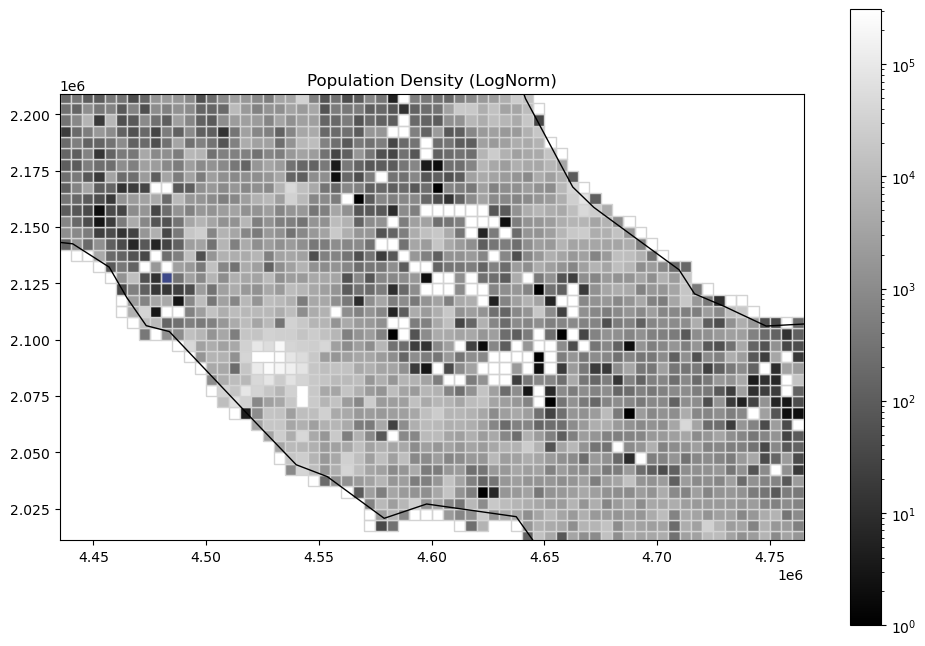

In [83]:
ax = gdf_grid_5km_merged.plot(column="mice_occurrence", figsize=(12, 8))
plt.title("Population Density (LogNorm)")
plt.autoscale(False)
gdf_grid_5km_merged.plot(ax=ax, cmap="gray", column="TOT_P_2021", edgecolor='lightgrey', norm=colors.LogNorm(), legend=True)
gdf_world.plot(ax=ax, color='none', edgecolor='black')

<Axes: title={'center': 'Mice Occurrence Density'}>

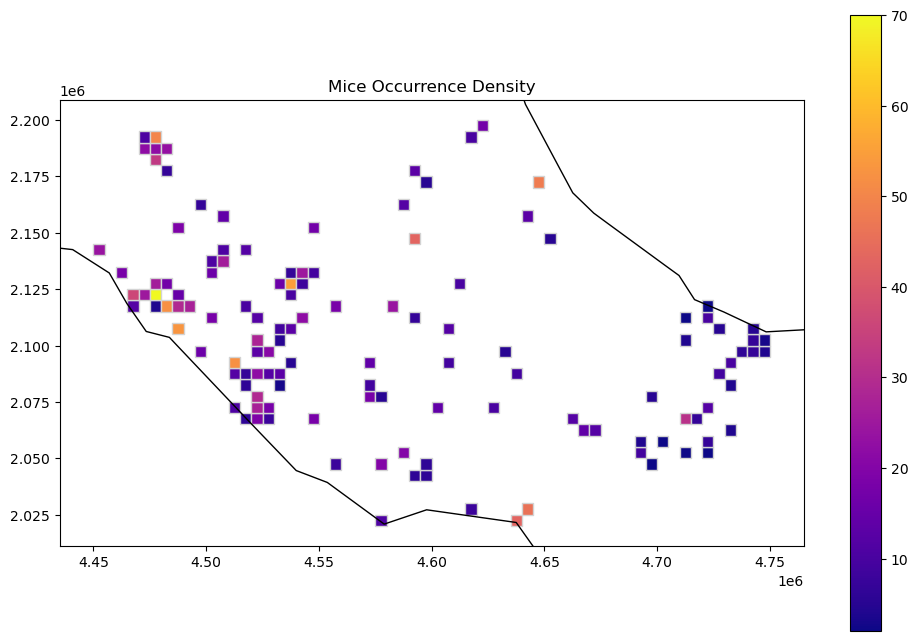

In [84]:
ax = gdf_grid_5km_merged.plot(column="mice_occurrence", figsize=(12, 8))
plt.title("Mice Occurrence Density")
plt.autoscale(False)
gdf_grid_5km_merged.plot(ax=ax, cmap="plasma", column="mice_occurrence", edgecolor='lightgrey', legend=True)
gdf_world.plot(ax=ax, color='none', edgecolor='black')

### UAA - Utilised agricultural area (Hectare)

In [98]:
gdf_agri_uaa = gpd.read_file("data/geospatial_data_from_agricultural_census/c17/c17.shp")

In [99]:
gdf_agri_uaa.head()

,ID,res,area,nuts2,HOLDING,SO_EURO,UAA,HldnPK2,UAAprHl,SOprHld,geometry
0,1,1000,0.7165,MT00,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4715000.000 1450000.000, 4715000.000..."
1,2,1000,1.0000,MT00,60.0,348000.0,70.0,60.0,1.20,5800.0,"POLYGON ((4717000.000 1444000.000, 4717000.000..."
2,3,1000,1.0000,MT00,110.0,350000.0,100.0,110.0,0.91,3200.0,"POLYGON ((4718000.000 1444000.000, 4718000.000..."
3,4,1000,1.0000,MT00,20.0,317000.0,30.0,20.0,1.50,16000.0,"POLYGON ((4719000.000 1444000.000, 4719000.000..."
4,5,1000,1.0000,MT00,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((4717000.000 1443000.000, 4717000.000..."


<Axes: >

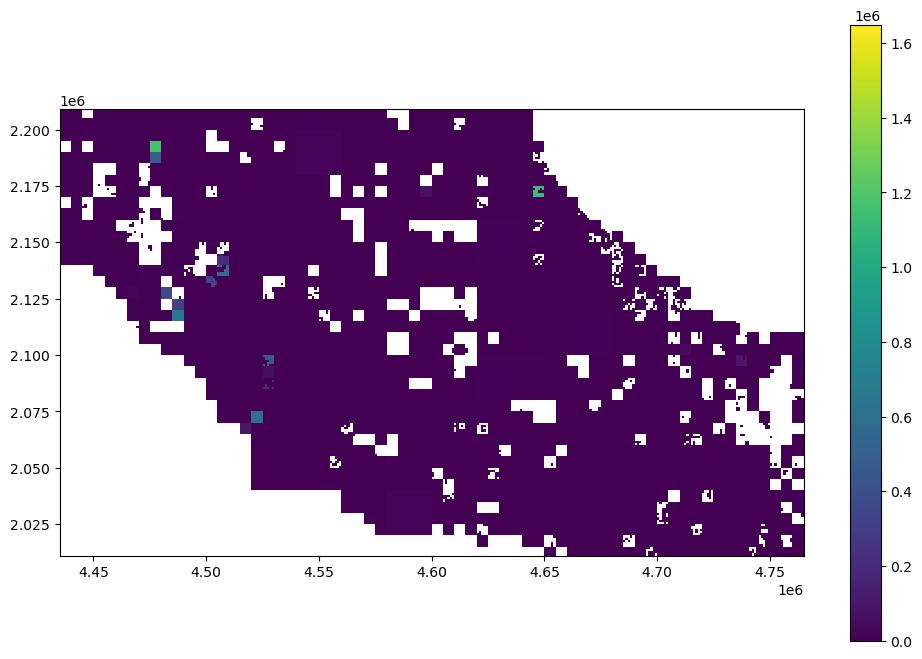

In [102]:
ax = gdf_grid_5km_merged.plot(column="mice_occurrence", figsize=(12, 8))
plt.autoscale(False)
gdf_agri_uaa.plot(ax=ax,column="UAA", legend=True)

<Axes: >

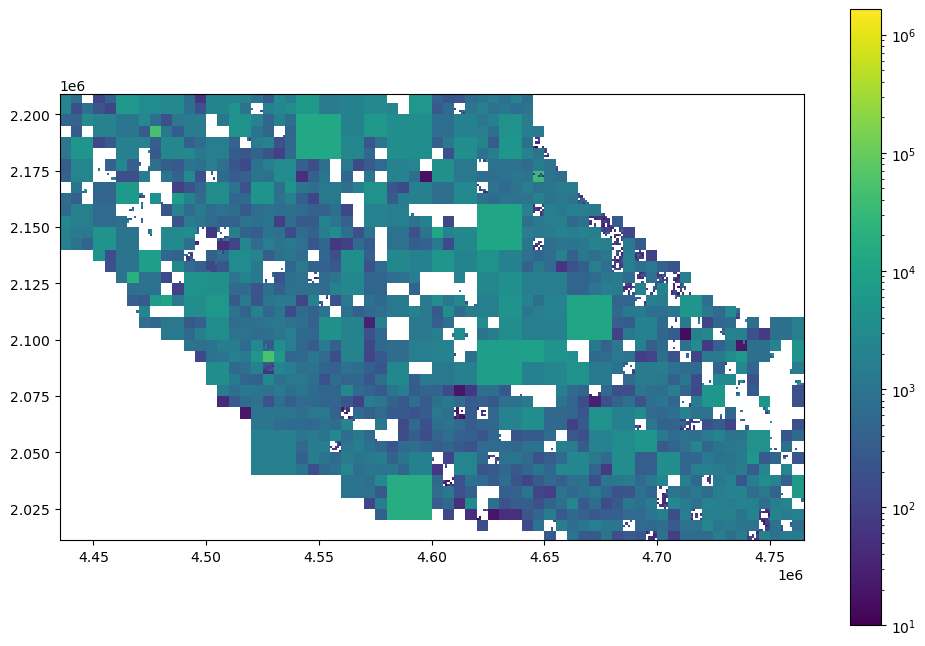

In [103]:
ax = gdf_grid_5km_merged.plot(column="mice_occurrence", figsize=(12, 8))
plt.autoscale(False)
gdf_agri_uaa.plot(ax=ax,column="UAA", legend=True, norm=colors.LogNorm())

In [358]:
gdf_grid_5km_uaa = gdf_grid_5km_merged.sjoin(gdf_agri_uaa.to_crs(gdf_grid_5km_merged.crs)[["geometry", "UAA"]], how="inner", predicate='intersects').to_crs("EPSG:4326")

In [359]:
gdf_grid_5km_merged["geometry"]

249       POLYGON ((4090000.000 2510000.000, 4095000.000...
250       POLYGON ((4095000.000 2510000.000, 4100000.000...
251       POLYGON ((4100000.000 2510000.000, 4105000.000...
252       POLYGON ((4105000.000 2510000.000, 4110000.000...
253       POLYGON ((4110000.000 2510000.000, 4115000.000...
                                ...                        
290176    POLYGON ((4540000.000 2505000.000, 4545000.000...
290178    POLYGON ((4545000.000 2505000.000, 4550000.000...
290179    POLYGON ((4550000.000 2505000.000, 4555000.000...
290180    POLYGON ((4555000.000 2505000.000, 4560000.000...
290181    POLYGON ((4560000.000 2505000.000, 4565000.000...
Name: geometry, Length: 12941, dtype: geometry

In [360]:
gdf_agri_uaa.to_crs(gdf_grid_5km_merged.crs)["geometry"]

0         POLYGON ((4715000.000 1450000.000, 4715000.000...
1         POLYGON ((4717000.000 1444000.000, 4717000.000...
2         POLYGON ((4718000.000 1444000.000, 4718000.000...
3         POLYGON ((4719000.000 1444000.000, 4719000.000...
4         POLYGON ((4717000.000 1443000.000, 4717000.000...
                                ...                        
129810    POLYGON ((5400000.000 1560000.000, 5400000.000...
129811    POLYGON ((5560000.000 1480000.000, 5560000.000...
129812    POLYGON ((1960000.000 1000000.000, 1960000.000...
129813    POLYGON ((1760000.000 960000.000, 1760000.000 ...
129814    POLYGON ((1920000.000 960000.000, 1920000.000 ...
Name: geometry, Length: 129815, dtype: geometry

In [132]:
gdf_grid_5km_uaa["UAA"].value_counts()

UAA
50.0       647
70.0       644
110.0      638
90.0       637
60.0       624
          ... 
5350.0       1
7770.0       1
6610.0       1
15600.0      1
5520.0       1
Name: count, Length: 683, dtype: int64

In [124]:
gdf_grid_5km_uaa["mice_occurrence"].value_counts()

mice_occurrence
12.0    10
5.0      9
7.0      9
10.0     7
9.0      7
6.0      6
18.0     6
2.0      6
4.0      6
11.0     5
13.0     5
22.0     4
8.0      4
14.0     4
16.0     3
17.0     3
25.0     2
26.0     2
24.0     2
52.0     2
3.0      2
43.0     2
20.0     2
27.0     2
19.0     2
29.0     2
23.0     1
33.0     1
48.0     1
55.0     1
46.0     1
70.0     1
15.0     1
36.0     1
31.0     1
53.0     1
28.0     1
21.0     1
50.0     1
Name: count, dtype: int64

Text(0.5, 1.0, 'UAA')

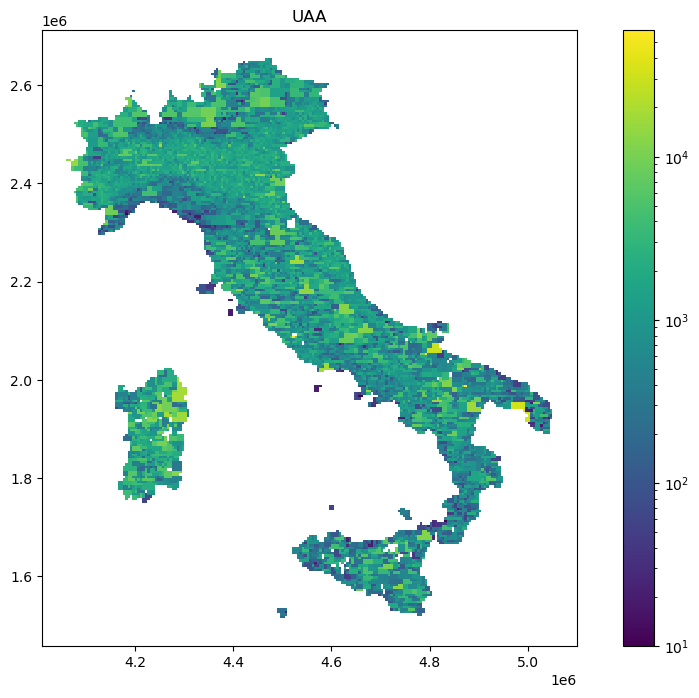

In [140]:
gdf_grid_5km_uaa.plot(column="UAA", norm=colors.LogNorm(), figsize=(12,8), legend=True)
plt.title("UAA")

In [363]:
gdf_grid_5km_uaa

,DIST_BORD,TOT_P_2018,TOT_P_2006,GRD_ID,TOT_P_2011,TOT_P_2021,Y_LLC,CNTR_ID,NUTS2016_3,NUTS2016_2,...,X_LLC,NUTS2021_3,NUTS2021_2,DIST_COAST,NUTS2021_1,NUTS2021_0,geometry,mice_occurrence,index_right,UAA
249,7329.919922,23.0,2.0,CRS3035RES5000mN2510000E4090000,25.0,24,2510000,IT,ITC20,ITC2,...,4090000,ITC20,ITC2,188582.968750,ITC,IT,"POLYGON ((7.03926 45.66127, 7.10329 45.66304, ...",NaN,129042,4710.0
250,11601.150391,664.0,680.0,CRS3035RES5000mN2510000E4095000,671.0,797,2510000,IT,ITC20,ITC2,...,4095000,ITC20,ITC2,185743.750000,ITC,IT,"POLYGON ((7.10329 45.66304, 7.16733 45.66477, ...",NaN,123184,NaN
250,11601.150391,664.0,680.0,CRS3035RES5000mN2510000E4095000,671.0,797,2510000,IT,ITC20,ITC2,...,4095000,ITC20,ITC2,185743.750000,ITC,IT,"POLYGON ((7.10329 45.66304, 7.16733 45.66477, ...",NaN,129042,4710.0
250,11601.150391,664.0,680.0,CRS3035RES5000mN2510000E4095000,671.0,797,2510000,IT,ITC20,ITC2,...,4095000,ITC20,ITC2,185743.750000,ITC,IT,"POLYGON ((7.10329 45.66304, 7.16733 45.66477, ...",NaN,88084,2150.0
250,11601.150391,664.0,680.0,CRS3035RES5000mN2510000E4095000,671.0,797,2510000,IT,ITC20,ITC2,...,4095000,ITC20,ITC2,185743.750000,ITC,IT,"POLYGON ((7.10329 45.66304, 7.16733 45.66477, ...",NaN,87842,1120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290181,43628.628906,412.0,1240.0,CRS3035RES5000mN2505000E4560000,395.0,503,2505000,IT,ITH35-ITH42,ITH3-ITH4,...,4560000,ITH35-ITH42,ITH3-ITH4,46.540001,ITH,IT,"POLYGON ((13.06066 45.61335, 13.12462 45.61148...",NaN,123194,850.0
290181,43628.628906,412.0,1240.0,CRS3035RES5000mN2505000E4560000,395.0,503,2505000,IT,ITH35-ITH42,ITH3-ITH4,...,4560000,ITH35-ITH42,ITH3-ITH4,46.540001,ITH,IT,"POLYGON ((13.06066 45.61335, 13.12462 45.61148...",NaN,88368,60.0
290181,43628.628906,412.0,1240.0,CRS3035RES5000mN2505000E4560000,395.0,503,2505000,IT,ITH35-ITH42,ITH3-ITH4,...,4560000,ITH35-ITH42,ITH3-ITH4,46.540001,ITH,IT,"POLYGON ((13.06066 45.61335, 13.12462 45.61148...",NaN,88148,760.0
290181,43628.628906,412.0,1240.0,CRS3035RES5000mN2505000E4560000,395.0,503,2505000,IT,ITH35-ITH42,ITH3-ITH4,...,4560000,ITH35-ITH42,ITH3-ITH4,46.540001,ITH,IT,"POLYGON ((13.06066 45.61335, 13.12462 45.61148...",NaN,88149,130.0


## Handling .nc file
Refer to: https://spatial-dev.guru/2024/01/20/get-the-geographical-coordinates-from-netcdf-file-using-python/

In [162]:
# %pip install rioxarray

In [178]:
import xarray as xr
import math

In [235]:
def convert_nc_to_gdf(nc_path, shp_path):
    ds = xr.open_dataset(nc_path, decode_coords="all")
    x, y = np.meshgrid(ds.longitude, ds.latitude)
    variables = list(ds.var())
    variable_name = variables[0]
    raster_values = ds[variable_name][0].values

    df = pd.DataFrame({
    "x": x.flatten(),
    "y": y.flatten(),
    "raster_value": raster_values.flatten()
    })
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))
    gdf[~gdf["raster_value"].apply(lambda x: math.isnan(x))].drop(columns=["x","y"]).rename(columns={"raster_value": variable_name}).to_file(shp_path)

### Mean temperature (0.25)

In [236]:
convert_nc_to_gdf("data/tg_ens_mean_0.25deg_reg_2011-2024_v30.0e.nc/tg_ens_mean_0.25deg_reg_2011-2024_v30.0e.nc",
                  "data/tg_ens_mean_0.25deg_reg_2011-2024_v30.0e.nc/tg_ens_mean_0.25deg_reg_2011-2024_v30.0e.shp")

In [345]:
gdf_mean_temp = gpd.read_file("data/tg_ens_mean_0.25deg_reg_2011-2024_v30.0e.nc/tg_ens_mean_0.25deg_reg_2011-2024_v30.0e.shp")

In [346]:
gdf_mean_temp = gdf_mean_temp.set_crs("EPSG:4326")

In [347]:
gdf_mean_temp.head()

,tg,geometry
0,20.609999,POINT (-14.62500 25.37500)
1,20.570000,POINT (-14.37500 25.37500)
2,20.549999,POINT (-14.12500 25.37500)
3,20.340000,POINT (-13.87500 25.37500)
4,20.250000,POINT (-13.62500 25.37500)


Text(0.5, 1.0, 'gdf_mean_temp')

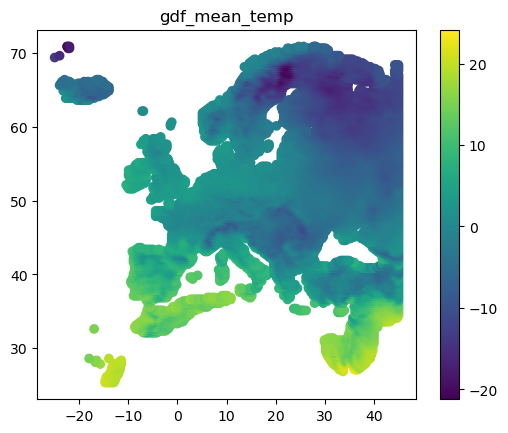

In [348]:
gdf_mean_temp.plot(column="tg", legend=True)
plt.title("gdf_mean_temp")

### Precipitation (0.25)

In [243]:
convert_nc_to_gdf("data/rr_ens_mean_0.25deg_reg_2011-2024_v30.0e/rr_ens_mean_0.25deg_reg_2011-2024_v30.0e.nc",
                  "data/rr_ens_mean_0.25deg_reg_2011-2024_v30.0e/rr_ens_mean_0.25deg_reg_2011-2024_v30.0e.shp")

In [349]:
gdf_precip = gpd.read_file("data/rr_ens_mean_0.25deg_reg_2011-2024_v30.0e/rr_ens_mean_0.25deg_reg_2011-2024_v30.0e.shp")

In [350]:
gdf_precip = gdf_precip.set_crs("EPSG:4326")

In [351]:
gdf_precip.head()

,rr,geometry
0,0.0,POINT (-14.62500 25.37500)
1,0.0,POINT (-14.37500 25.37500)
2,0.0,POINT (-14.12500 25.37500)
3,0.0,POINT (-13.87500 25.37500)
4,0.0,POINT (-13.62500 25.37500)


Text(0.5, 1.0, 'gdf_precip')

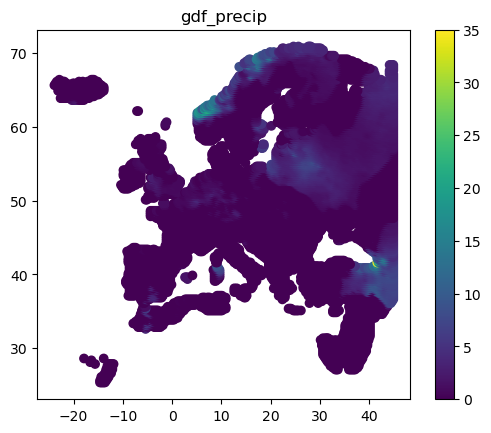

In [352]:
gdf_precip.plot(column="rr", legend=True)
plt.title("gdf_precip")

In [353]:
gdf_precip.rr.value_counts()

rr
0.000000     12602
1.500000       291
1.400000       287
1.700000       272
1.300000       263
             ...  
18.400000        1
17.300001        1
14.900001        1
17.800001        1
14.600000        1
Name: count, Length: 171, dtype: int64

## Merge with GDF_Grid_5km

<Axes: >

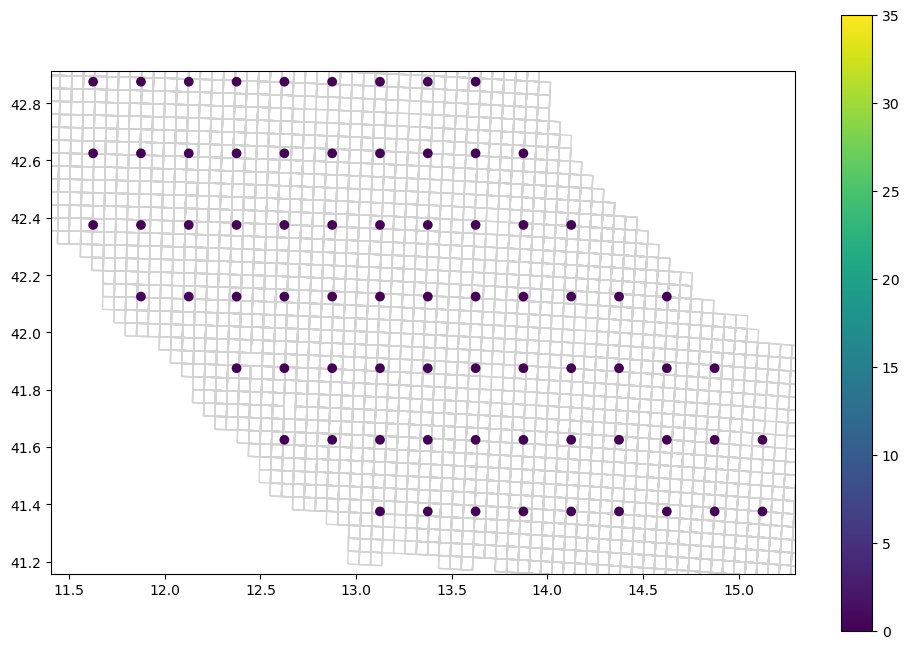

In [361]:
ax = gdf_mice.plot(markersize=0, figsize=(12,8))
plt.autoscale(False)
gdf_grid_5km_uaa.plot(ax=ax, column="UAA", facecolor="none", edgecolor="lightgrey")
gdf_precip.plot(ax=ax, column="rr", legend=True)

<Axes: >

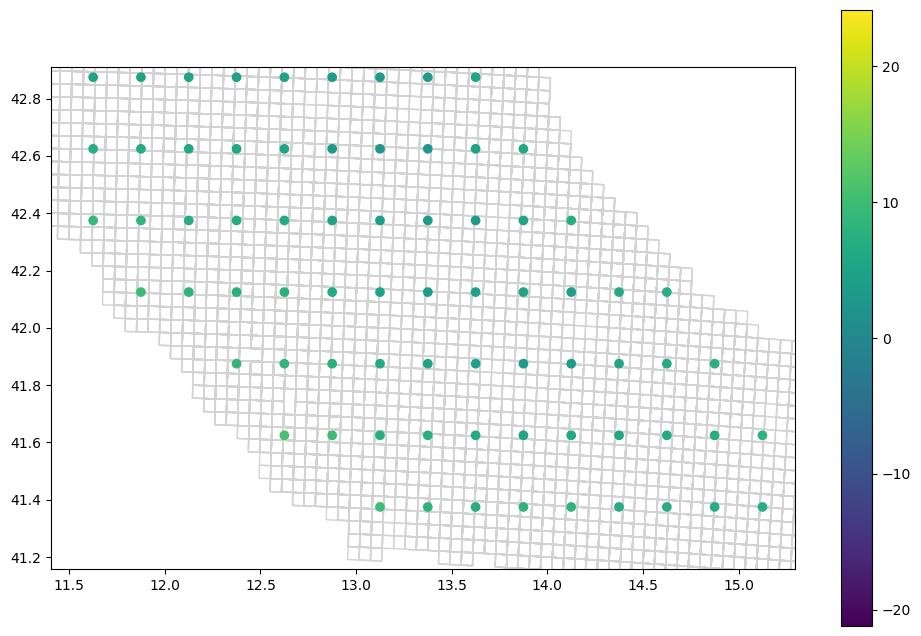

In [362]:
ax = gdf_mice.plot(markersize=0, figsize=(12,8))
plt.autoscale(False)
gdf_grid_5km_uaa.plot(ax=ax, column="UAA", facecolor="none", edgecolor="lightgrey")
gdf_mean_temp.plot(ax=ax, column="tg", legend=True)

→気温．降水量の粒度低い！0.25degではなく0.1degでやろう

### Mean temperature & Precipitation(0.1)

In [ ]:
convert_nc_to_gdf("data/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e.nc",
                  "data/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e.shp")

In [365]:
convert_nc_to_gdf("data/rr_ens_mean_0.1deg_reg_2011-2024_v30.0e/rr_ens_mean_0.1deg_reg_2011-2024_v30.0e.nc",
                  "data/rr_ens_mean_0.1deg_reg_2011-2024_v30.0e/rr_ens_mean_0.1deg_reg_2011-2024_v30.0e.shp")

In [366]:
gdf_mean_temp = gpd.read_file("data/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e.shp")
gdf_precip = gpd.read_file("data/rr_ens_mean_0.1deg_reg_2011-2024_v30.0e/rr_ens_mean_0.1deg_reg_2011-2024_v30.0e.shp")

<Axes: >

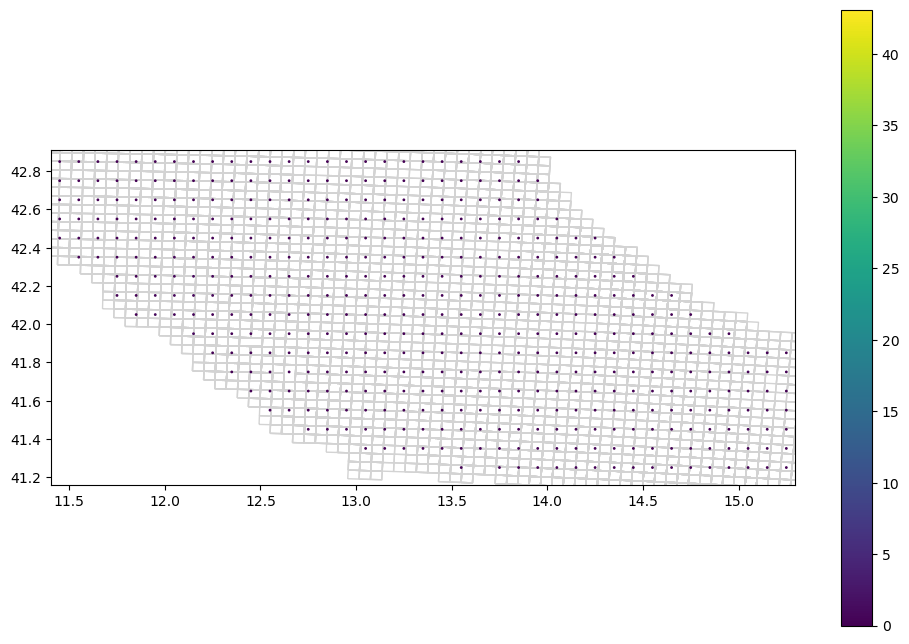

In [370]:
ax = gdf_mice.plot(markersize=0, figsize=(12,8))
plt.autoscale(False)
gdf_grid_5km_uaa.plot(ax=ax, column="UAA", facecolor="none", edgecolor="lightgrey")
gdf_precip.plot(ax=ax, column="rr", legend=True, markersize=1)

<Axes: >

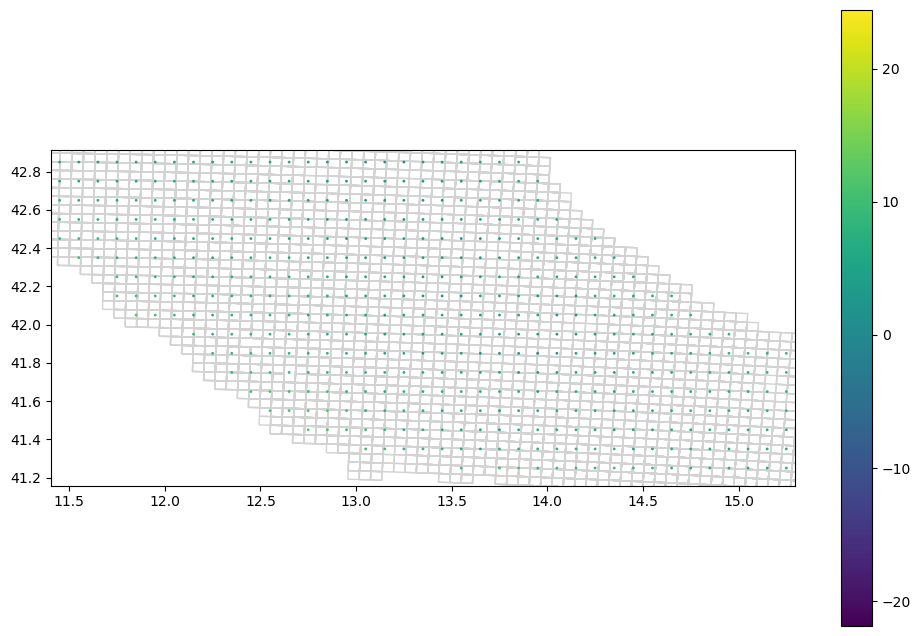

In [371]:
ax = gdf_mice.plot(markersize=0, figsize=(12,8))
plt.autoscale(False)
gdf_grid_5km_uaa.plot(ax=ax, column="UAA", facecolor="none", edgecolor="lightgrey")
gdf_mean_temp.plot(ax=ax, column="tg", legend=True, markersize=1)

# 10km四方か20km四方の方がbetter?

In [379]:
# 人口密度メッシュ（10km四方）
gdf_grid_10km = gpd.read_file("data/grid/grid_10km_surf.gpkg")
gdf_grid_10km = gdf_grid_10km[gdf_grid_10km["CNTR_ID"] == "IT"].to_crs("EPSG:4326")

In [380]:
# 人口密度メッシュ（20km四方）
gdf_grid_20km = gpd.read_file("data/grid/grid_20km_surf.gpkg")
gdf_grid_20km = gdf_grid_20km[gdf_grid_20km["CNTR_ID"] == "IT"].to_crs("EPSG:4326")

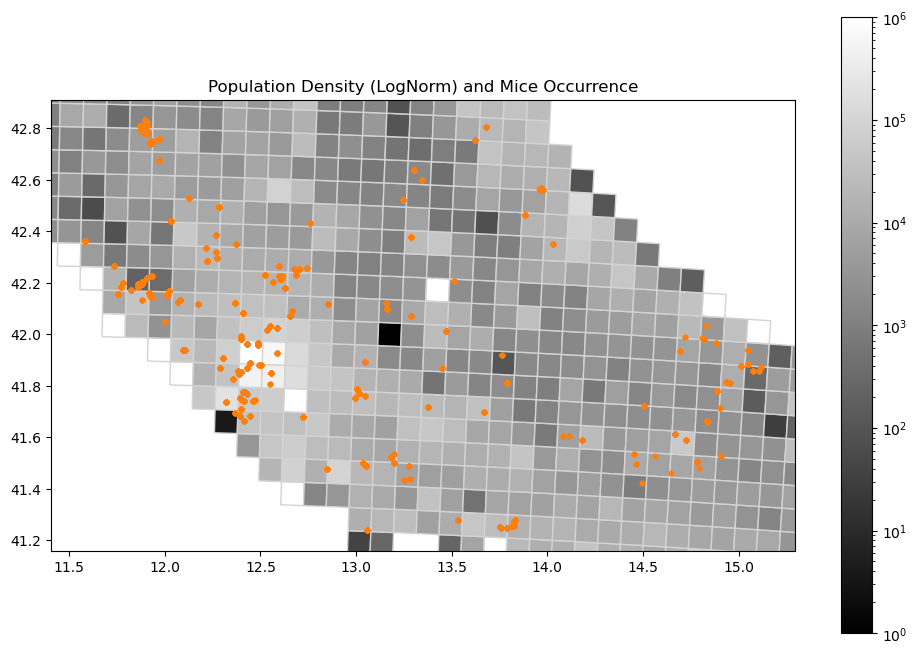

In [381]:
plot_gdfs(gdf_mice,gdf_grid_10km,True)

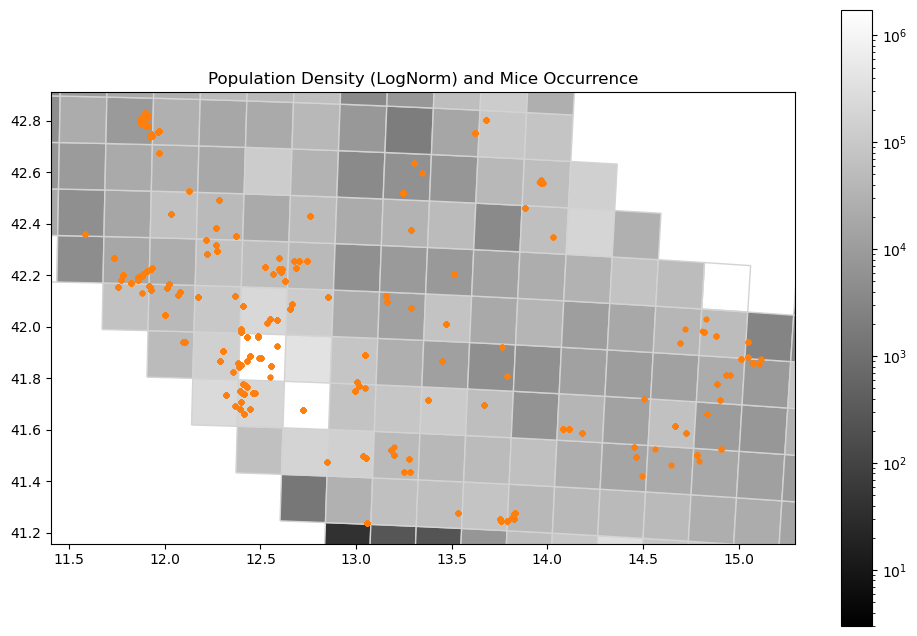

In [382]:
plot_gdfs(gdf_mice,gdf_grid_20km,True)

<Axes: >

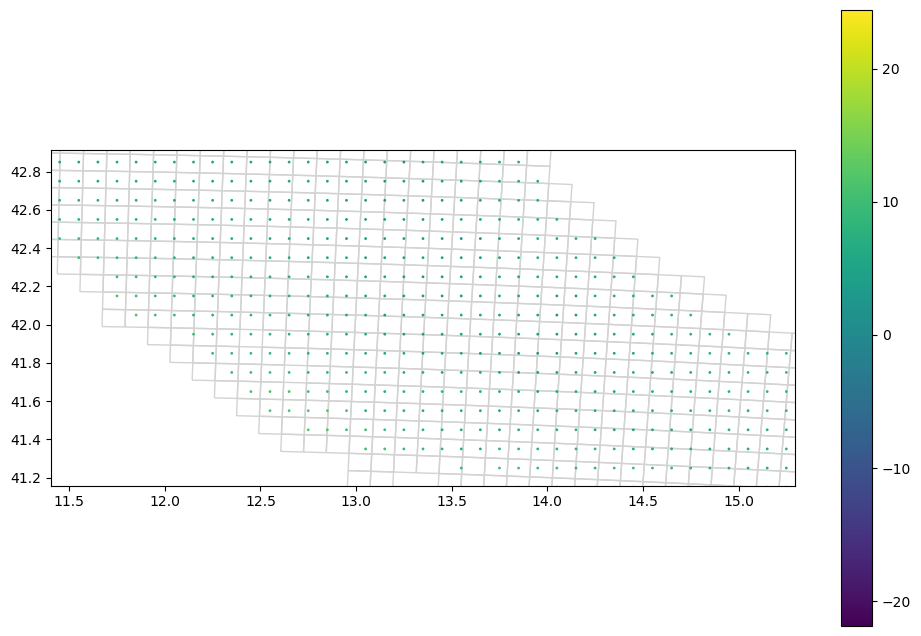

In [383]:
ax = gdf_mice.plot(markersize=0, figsize=(12,8))
plt.autoscale(False)
gdf_grid_10km.plot(ax=ax, facecolor="none", edgecolor="lightgrey")
gdf_mean_temp.plot(ax=ax, column="tg", legend=True, markersize=1)

<Axes: >

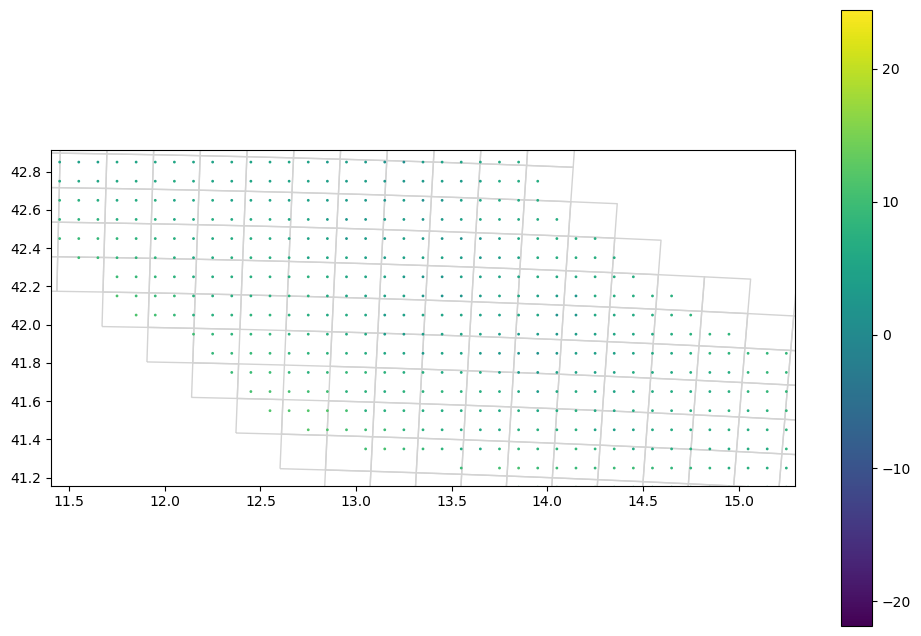

In [384]:
ax = gdf_mice.plot(markersize=0, figsize=(12,8))
plt.autoscale(False)
gdf_grid_20km.plot(ax=ax, facecolor="none", edgecolor="lightgrey")
gdf_mean_temp.plot(ax=ax, column="tg", legend=True, markersize=1)

→10km四方がちょうど良さそう

## ここからの流れ
1. 10km四方で気温，降水量，ねずみoccurrence，人口密度を突っ込んだgdf作る
2. neural networkで予測モデル作る: outputは連続値　(train_data=gdf[gdf[ねずみoccurrence]!=0])
3. Cross validationなどでテスト
4. 最終的に，gdf[gdf[ねずみoccurrence]=0]にも連続値を当てはめてみて，ネズミの発生分布をつくる
5. レポートにする！